In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *
from lightgbm import LGBMClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
sub = pd.read_csv('Dataset/sample_submission.csv')

In [3]:
train.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0
245724,BOCZSWLJ,Male,29,RG269,Salaried,X1,21,No,1129276,No,0


In [4]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [5]:
test.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
dtype: object

In [6]:
train.Is_Active.value_counts()

No     150290
Yes     95435
Name: Is_Active, dtype: int64

In [7]:
train.fillna("NA",inplace=True)
test.fillna("NA",inplace=True)

In [8]:
gender_mapper = {"Female":1,"Male":0}
train['Gender'] = train.Gender.map(gender_mapper)
test['Gender'] = test.Gender.map(gender_mapper)

In [9]:
occ_mapper = {"Self_Employed":1,"Salaried":0,"Other":2,"Entrepreneur":3}
train['Occupation'] = train.Occupation.map(occ_mapper)
test['Occupation'] = test.Occupation.map(occ_mapper)

In [10]:
train['Region_Code'] = train.Region_Code.str[2:].astype(int)
test['Region_Code'] = test.Region_Code.str[2:].astype(int)

In [11]:
train['Channel_Code'] = train.Channel_Code.str[1:].astype(int)
test['Channel_Code'] = test.Channel_Code.str[1:].astype(int)

In [12]:
cp_mapper = {"No":1,"NA":0,"Yes":2}
train['Credit_Product'] = train.Credit_Product.map(cp_mapper)
test['Credit_Product'] = test.Credit_Product.map(cp_mapper)

In [13]:
is_active_mapper = {"Yes":1,"No":0}
train['Is_Active'] = train.Is_Active.map(is_active_mapper)
test['Is_Active'] = test.Is_Active.map(is_active_mapper)

In [14]:
train['age_bin'] = np.where((train.Age>40)&(train.Age<65),1,0)
test['age_bin'] = np.where((test.Age>40)&(test.Age<65),1,0)

In [15]:
selected_columns = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']
len(selected_columns)

9

In [16]:
X = train[selected_columns]
y = train.Is_Lead

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify = y)

In [18]:
model =LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=30,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=150,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    silent=True,
    importance_type='split'
)

In [19]:
model.fit(X_train,y_train)

LGBMClassifier(max_depth=7, n_estimators=150, num_leaves=30, random_state=42)

In [20]:
model.predict(X_test[selected_columns])

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

<AxesSubplot:>

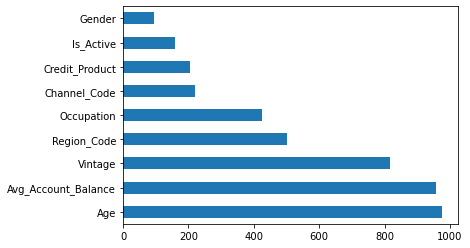

In [21]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))  

In [22]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8724473949682701

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
scores = cross_val_score(model, X, y, cv=10,scoring = 'roc_auc')
print(scores,scores.mean())

[0.87256031 0.87239546 0.87380605 0.87499167 0.8697583  0.87693161
 0.87411829 0.87384953 0.87650922 0.87471164] 0.8739632084242451


In [25]:
model.fit(X,y)

LGBMClassifier(max_depth=7, n_estimators=150, num_leaves=30, random_state=42)

In [26]:
preds = model.predict_proba(test[selected_columns])[:, 1]

In [27]:
result = pd.DataFrame()
result['ID'] = test.ID
result['Is_Lead'] = preds

In [28]:
result.describe()

,Is_Lead
count,105312.000000
mean,0.237348
std,0.277046
min,0.007361
25%,0.053324
50%,0.087789
75%,0.332982
max,0.999088


In [29]:
result.to_csv('base_model_results.csv',index=False)